In [1]:
pip install --force-reinstall git+https://github.com/amyfricke/clairvoyants.git

  Cloning https://github.com/amyfricke/clairvoyants.git to /tmp/pip-req-build-zlnama04
  Running command git clone --filter=blob:none --quiet https://github.com/amyfricke/clairvoyants.git /tmp/pip-req-build-zlnama04
  Resolved https://github.com/amyfricke/clairvoyants.git to commit 06c4c35a5a3598a7cd7cc550ab8c7c10e7945ace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clairvoyants: filename=clairvoyants-0.0.1-py3-none-any.whl size=29182 sha256=23f953c30c51f7f34fd058ec7c717150d3da3b581157b1cfebc9ec5e7665a5d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2v5uqba/wheels/d0/c6/b6/4b21b33f502b63dce5568e2e87793224d96a9d03778a79f47a
Successfully built clairvoyants
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that

# Using clairvoyants to forecast
In this notebook, we demonstrate how clairvoyants can be used to forecast a simulated time series that includes dramatic short-term effects from the pandemic. The series represents a usage metric—such as daily logins—that experienced a temporary surge during pandemic restrictions.

Our goal is to generate forecasts without allowing this temporary spike to distort the underlying trend or bias other parameter estimates. To achieve this, we include a feature indicating whether pandemic restrictions were in place, so the model can explicitly account for and isolate that effect.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from clairvoyants import Clairvoyant
from clairvoyants import ensemble
from clairvoyants.plot import human_format,  plot_pre_post_actuals_forecast, plot_ensemble
from clairvoyants.utilities import _datetime_delta


Importing plotly failed. Interactive plots will not work.


Below, we load the sample time series from the examples folder. As described above, the series exhibits seasonal patterns—such as a summer slump—and holiday effects, most notably around New Year’s.

These patterns are important to model explicitly. If ignored, they could be misattributed to other drivers, distorting the forecast and leading to incorrect conclusions about what is truly driving changes in the series.

In [16]:
pandemic_usage = pd.read_csv("../examples/sample_ts.csv")
pandemic_usage['dt'] = pd.to_datetime(pandemic_usage.dt)

Next, we load the features dataset, which includes a single feature capturing the impact of the pandemic beginning in March 2020. This feature takes on nonzero values for days affected by the pandemic and 0 otherwise. 

In [17]:
pandemic_users = pd.read_csv("../examples/sample_covariates.csv")
pandemic_users['dt'] = pd.to_datetime(pandemic_users.dt)

Next we load in the holidays data frame that captures the New Years bump and the summer slump, as per the way the time series was simulated. 

In [13]:
holidays_df = pd.read_csv("../examples/holidays_df_example2.csv")
holidays_df['dt'] = pd.to_datetime(holidays_df.dt)

Next, we configure the forecast object to carry out the following steps in generating the forecast:

1. Aggregate seasonal components according to the `periods_agg` argument.

2. Provide the feature dataset through the `x_features argument` in the `.fit_ensemble` method, ensuring the features are aggregated consistently.

3. Augment the feature dataset by incorporating `holidays_df` and any sinusoidal terms corresponding to seasonalities specified in `periods_trig`. Here we specify `periods_trig` to be an empty list because seasonal effects were simulated as in how holiday effects are captured and thus are specified in the `holidays_df` argument. 


In [36]:
pandemic_clair = Clairvoyant(models=[ensemble.auto_sarimax, 
                                     ensemble.sarimax_013_011,
                                     ensemble.auto_scarf_nnet,
                                     ensemble.auto_sarif_nnet],
                             transform='log',
                             periods_trig=[],
                             periods_agg=[7],
                             holidays_df=holidays_df,
                             pred_level=0.9)

Here, we set `training_end_dt` so that a sufficient span of actual observations remains after the training window, allowing us to evaluate the forecast’s accuracy. 
4. Fit the ensemble of models defined in the `models` argument using the augmented feature dataset.”
5. Obtain the consensus forecast from the ensemble of models, defined as the median of their individual forecasts. 

In [37]:
pandemic_clair = pandemic_clair.fit_ensemble(df=pandemic_usage,
                                             training_end_dt=datetime(2021, 10, 10),
                                             forecast_end_dt=datetime(2022, 9, 14),
                                             x_features=pandemic_users)

/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6. Disaggregate the forecast back to the original time granularity specified. 
This is accomplished using a regression model on the daily proportions of the weekly total. 

In [38]:
pandemic_clair = pandemic_clair.disaggregate_forecasts(x_features_col_subset=['covid_indicator'])

/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


7. Calculate forecast error metrics using the portion of the data where actual observations are available for comparison against the forecast.

In [39]:
pandemic_clair = pandemic_clair.get_out_of_time_validation(
    df=pandemic_usage)

8. Examine the results

The plot below shows the forecasts (aggregated to the weekly level) for each model in the ensemble. Two models—the auto-SARIMA and the SARIF neural network—tend to over-forecast, while the SCARF neural network and the SARMIMA (0,2,3)(0,1,1) models lean toward under-forecasting. The consensus forecast, taken as the median, provides a balanced estimate that lies between these extremes. 

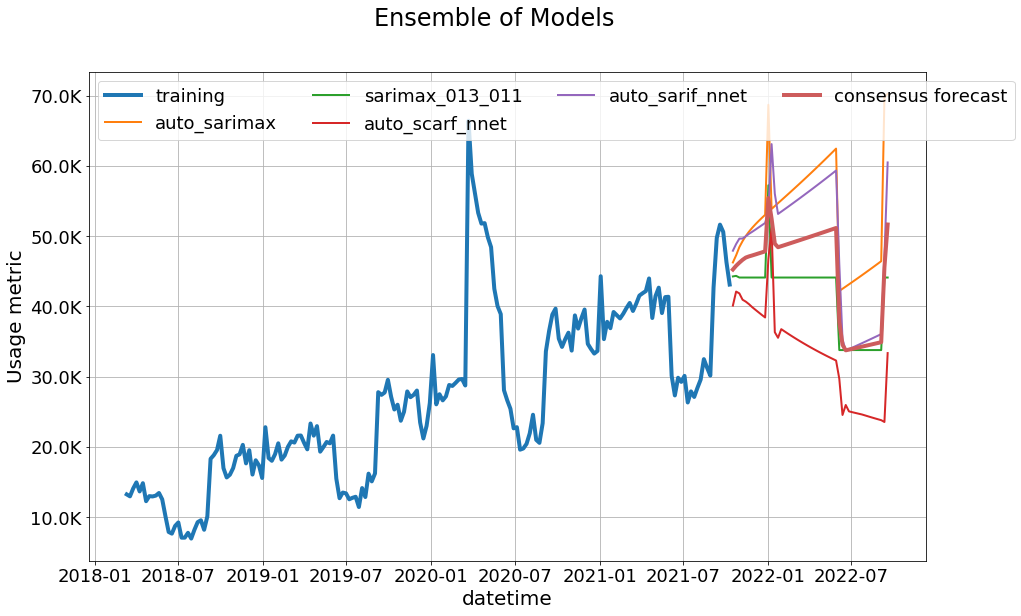

In [40]:
plot_ensemble(pandemic_clair, title='Ensemble of Models', ylabel='Usage metric')

Finally, we see that our consensus forecast does an excellent job of forecasting our simulated usage metric time series, and the coverage of the prediction intervals is well over 90%.  

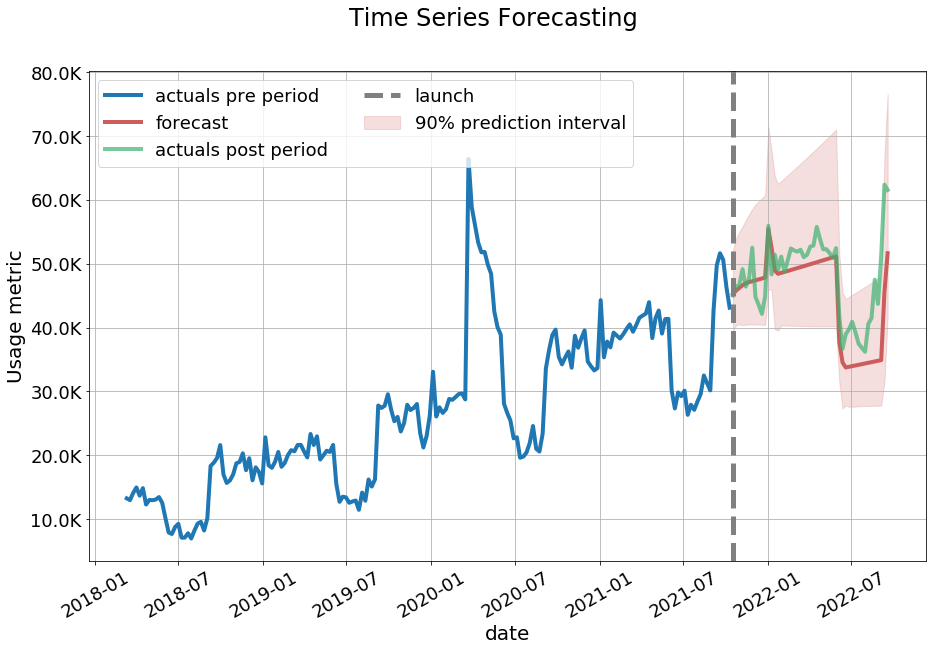

In [41]:
plot_pre_post_actuals_forecast(pandemic_clair, title='Time Series Forecasting', ylabel='Usage metric',
  pre_period=1200, post_period=50, use_aggregated=True)